# STRING

In [19]:
import pandas as pd

# Create a Dataframe of a Protein-Protein-Network

# Load STRING Protein-Protein Interaction (PPI) data and mapping file
ppi = pd.read_csv("raw_data/PPI/9606.protein.links.v12.0.txt.gz", sep=" ")
gene_name = pd.read_csv("raw_data/PPI/protein2gene.csv", sep='\t')

# Remove species prefix "9606." from ENSP IDs in PPI dataset
ppi["protein1"] = ppi["protein1"].str.replace("9606.", "", regex=False)
ppi["protein2"] = ppi["protein2"].str.replace("9606.", "", regex=False)

# Rename columns for clarity
gene_name = gene_name.rename(columns={"protein_ENSP": "protein", "gene name": "gene"})

# Map protein1 (source) to gene names using the gene_name lookup table
ppi = ppi.merge(gene_name, how="left", left_on="protein1", right_on="protein")
ppi = ppi.rename(columns={"gene": "source"})
ppi = ppi.drop(columns=["protein"])  # Remove redundant column after merge

# Map protein2 (target) to gene names using the same lookup table
ppi = ppi.merge(gene_name, how="left", left_on="protein2", right_on="protein")
ppi = ppi.rename(columns={"gene": "target"})
ppi = ppi.drop(columns=["protein"])  # Remove redundant column after merge


In [20]:
# Keep only relevant columns: source and target gene names
ppi = ppi[["source", "target", "combined_score"]]

# Filter out rows where either source or target gene is missing ("Not Found")
mask = (ppi['source'] != 'Not Found') & (ppi['target'] != 'Not Found')
final_ppi_string = ppi[mask]


print("Final Dataframe:")
print(final_ppi_string.head())

Final Dataframe:
  source    target  combined_score
0   ARF5   RALGPS2             173
1   ARF5     FHDC1             154
2   ARF5  ATP6V1E1             151
4   ARF5      PSD3             201
5   ARF5     TTC9C             180


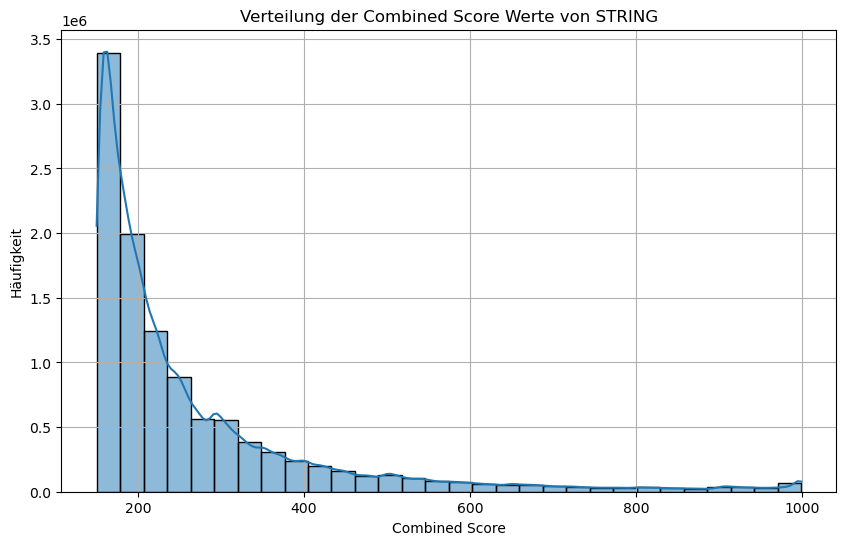

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verteilung der 'combined_score'-Spalte plotten
plt.figure(figsize=(10, 6))
sns.histplot(final_ppi_string['combined_score'], bins=30, kde=True)

plt.title('Verteilung der Combined Score Werte von STRING')
plt.xlabel('Combined Score')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()


In [7]:
median = final_ppi_string['combined_score'].median()
quantil_75 = final_ppi_string['combined_score'].quantile(0.75)
print(f"Median: {median}")
print(f"75% Quantil: {quantil_75}")

Median: 209.0
75% Quantil: 298.0


In [6]:
for t in [300, 500, 700]:
    print(f"Anzahl der Interaktionen bei Threshold {t}:")
    print(final_ppi_string[final_ppi_string['combined_score'] >= t].shape[0])

Anzahl der Interaktionen bei Threshold 300:
2717590
Anzahl der Interaktionen bei Threshold 500:
902484
Anzahl der Interaktionen bei Threshold 700:
374914


# IntAct

In [2]:
import re # for regular expressions (RegEx)
import pandas as pd # for Dataframe

# Functios to preprocess files
def extract_uniprotkb(text):
    """
    Extracts the UniProtKB identifier from a string.

    Parameters:
    - text: A string containing the UniProtKB ID.

    Returns:
    - string: The extracted UniProtKB ID or the original text if no ID is found.
    """
    match = re.search(r'uniprotkb:([A-Z0-9]+)', text)
    return match.group(1) if match else text

def extract_intact_miscore(text):
    """
    Extracts the Confidence value(s) (MI-Score) from a string.

    Parameters:
    - text: A string containing the MI-Score.

    Returns:
    - string: The extracted Confidence value(s) or the original text if no ID is found.
    """
    match = re.search(r'intact-miscore:([0-9.]+)', text)
    return float(match.group(1)) if match else None

def process_df(df):
    """
    Processes a DataFrame by extracting relevant information and applying functions to specific columns.

    Parameters:
    - df: A pandas DataFrame containing columns 'Protein', 'Interactor', 'Confidence value(s)', 'Database'.

    Returns:
    - pd.DataFrame: A processed DataFrame with additional columns for taxa and names.
    """
    df['Protein'] = df['#ID(s) interactor A'].apply(extract_uniprotkb)
    df['Interactor'] = df['ID(s) interactor B'].apply(extract_uniprotkb)
    df['intact_miscore'] = df['Confidence value(s)'].apply(extract_intact_miscore)
    df['Database'] = 'IntAct'
    return df

In [3]:
# IntAct
# Download human.txt (https://www.ebi.ac.uk/intact/interactomes for homo sapiens miTab 2.7) 
file_path_IntAct = "/sybig/home/tmu/Schreibtisch/Thesis/Networks/data/PPI/IntAct/human.txt"
IntAct_df = pd.read_csv(file_path_IntAct, sep="\t")


In [4]:
IntAct_df = process_df(IntAct_df)
selected_columns = ['Protein', 'Interactor', 'intact_miscore', 'Database']
IntAct_df = IntAct_df[selected_columns]
IntAct_df.rename(columns={"intact_miscore" : "Score"}, inplace=True)
print(IntAct_df.head())

# Missing Values?

missing_values = IntAct_df.isnull().sum()
strich_values = (IntAct_df == '-').sum()

print("Missing values (NaN):")
print(missing_values)

# Missing values: 81 for intact_miscore

print("\nMissing values ('-'):")
print(strich_values)

# Missing values: 204 for interactor

# Drop rows with missing value
IntAct_df_cleaned = IntAct_df[~(IntAct_df[['Protein', 'Interactor']] == '-').any(axis=1)]

  Protein Interactor  Score Database
0  P46109     Q13191   0.62   IntAct
1  Q13191     P46109   0.62   IntAct
2  P61769     P01899   0.44   IntAct
3  P36897     P62942   0.59   IntAct
4  F1MRS1     A6H772   0.52   IntAct
Missing values (NaN):
Protein        0
Interactor     0
Score         81
Database       0
dtype: int64

Missing values ('-'):
Protein         0
Interactor    204
Score           0
Database        0
dtype: int64


In [ ]:
## Mapping

import pandas as pd
import requests
import time
from tqdm import tqdm
import numpy as np

unique_uniprot_ids = pd.concat([IntAct_df_cleaned['Protein'], IntAct_df_cleaned['Interactor']]).dropna().unique()

# Konvertiere zuerst zu einer Liste oder numpy array
unique_uniprot_list = unique_uniprot_ids.tolist()

# Filtere alle Einträge, die NICHT mit 'intact:' beginnen
filtered_uniprot_list = [uid for uid in unique_uniprot_list if not uid.startswith('intact:')]

# Optional: wieder als numpy.ndarray (falls gewünscht)
filtered_uniprot_ids = np.array(filtered_uniprot_list)


unique_uniprot_df = pd.DataFrame({'UniProt_ID': filtered_uniprot_ids})


       UniProt_ID
0          P46109
1          Q13191
2          P61769
3          P36897
4          F1MRS1
...           ...
45723      Q9Y5H1
45724      B3KU38
45725      Q6IS24
45726  A0A140T963
45727      C9JI98

[45728 rows x 1 columns]


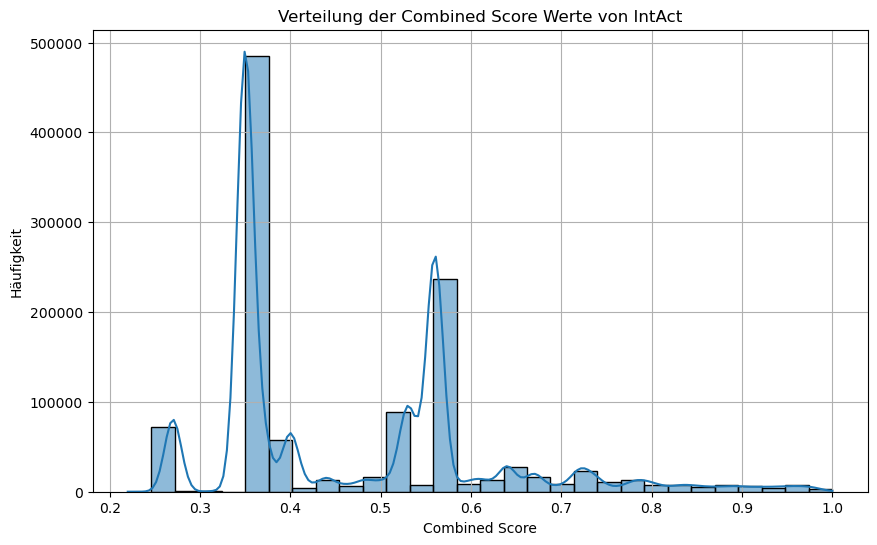

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verteilung der 'combined_score'-Spalte plotten
plt.figure(figsize=(10, 6))
sns.histplot(IntAct_df_cleaned['Score'], bins=30, kde=True)

plt.title('Verteilung der Combined Score Werte von IntAct')
plt.xlabel('Combined Score')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()


In [16]:
median = IntAct_df_cleaned['Score'].median()
quantil_75 = IntAct_df_cleaned['Score'].quantile(0.75)
print(f"Median: {median}")
print(f"75% Quantil: {quantil_75}")

Median: 0.4
75% Quantil: 0.56


In [17]:
for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
    print(f"Anzahl der Interaktionen bei Threshold {t}:")
    print(IntAct_df_cleaned[IntAct_df_cleaned['Score'] >= t].shape[0])

Anzahl der Interaktionen bei Threshold 0.3:
1088015
Anzahl der Interaktionen bei Threshold 0.4:
602185
Anzahl der Interaktionen bei Threshold 0.5:
509229
Anzahl der Interaktionen bei Threshold 0.6:
167049
Anzahl der Interaktionen bei Threshold 0.7:
102516
